# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

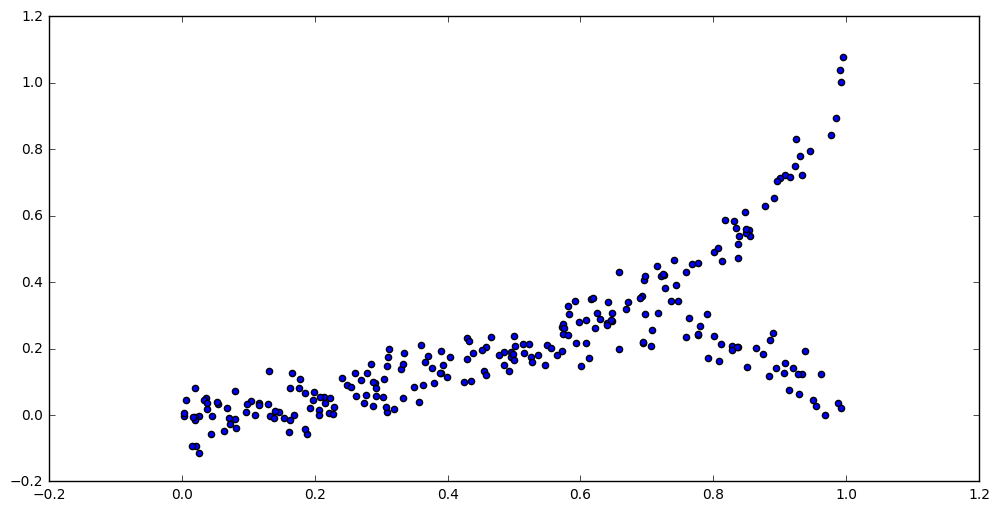

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, variance=0.01, prior_Z='DP')
m.log_likelihood()

1173.8270035867843

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

plotter.py:23: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(XX[:, 0],YY_mu - 2.*np.sqrt(YY_var),\
plotter.py:24: RuntimeWarning: invalid value encountered in sqrt
  YY_mu + 2.*np.sqrt(YY_var),alpha=0.1,facecolor=col)


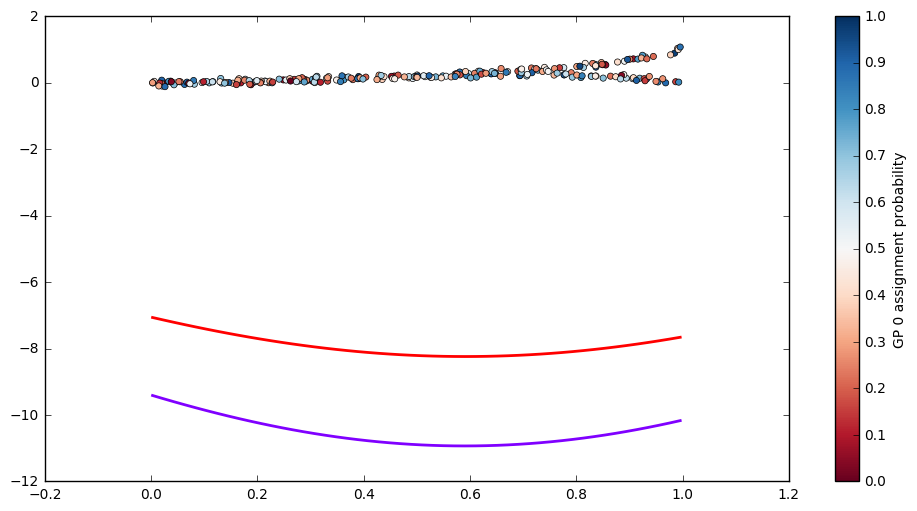

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

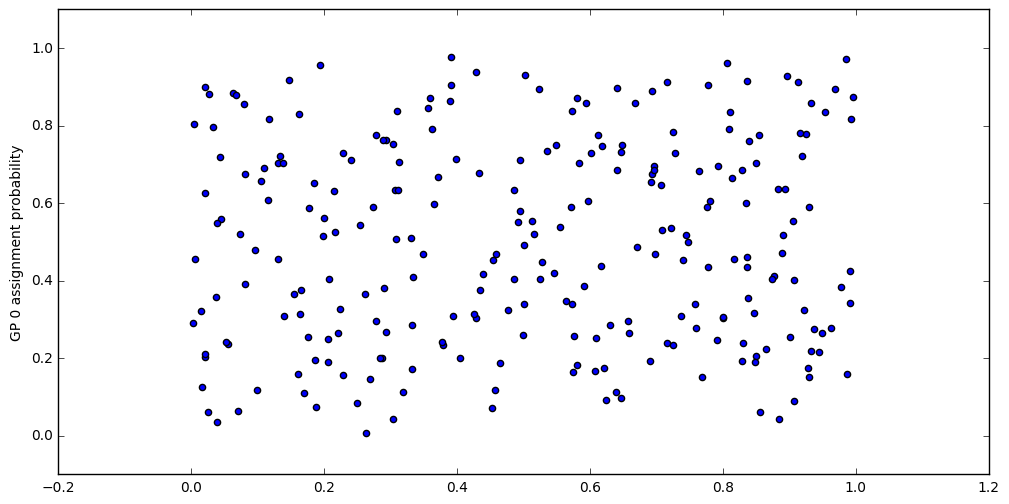

In [6]:
from plotter import OMGPplot_probs
OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [7]:
m.optimize(step_length=0.01)

iteration 1 bound=1177.96524828 grad=414.072000691, beta=0
iteration 2 bound=1185.87082819 grad=372.514617671, beta=1.01585740684
iteration 3 bound=1196.94069452 grad=318.273430761, beta=1.01500577685
iteration 4 bound=1209.8519395 grad=260.064539068, beta=0.9848703327
iteration 5 bound=1222.48200413 grad=201.32784654, beta=0.932618225116
iteration 6 bound=1233.2517234 grad=148.060955635, beta=0.877994063101
iteration 7 bound=1241.52970453 grad=104.516196264, beta=0.830611536127
iteration 8 bound=1247.25495249 grad=72.2702781808, beta=0.783000330554
iteration 9 bound=1250.85097863 grad=51.132000112, beta=0.724163842801
iteration 10 bound=1253.07016945 grad=38.2487539457, beta=0.691947743748
iteration 11 bound=1254.60948209 grad=29.6704644527, beta=0.75234754101
iteration 12 bound=1255.77842831 grad=22.8682992341, beta=0.821181713673
iteration 13 bound=1256.68169748 grad=17.2459004113, beta=0.851275697387
iteration 14 bound=1257.36303012 grad=12.8522506075, beta=0.851907519693
iteration

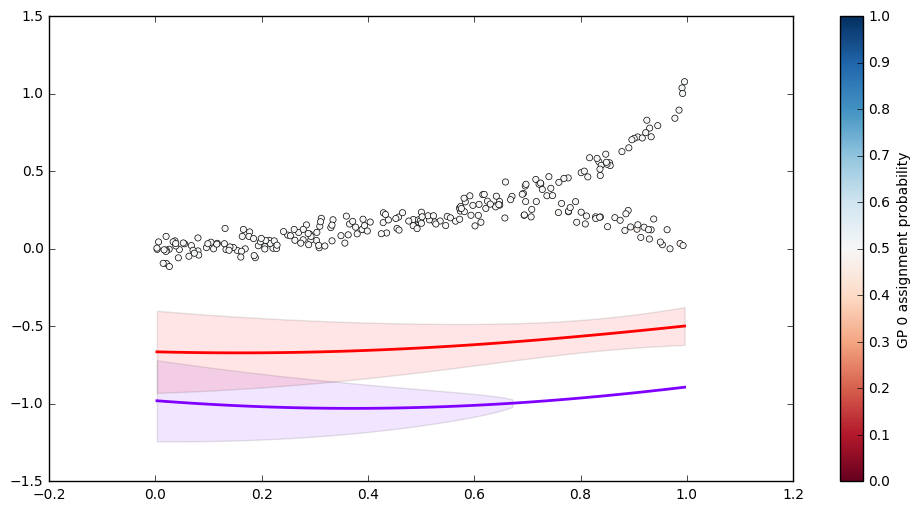

In [8]:
OMGPplot(m,X,Y)

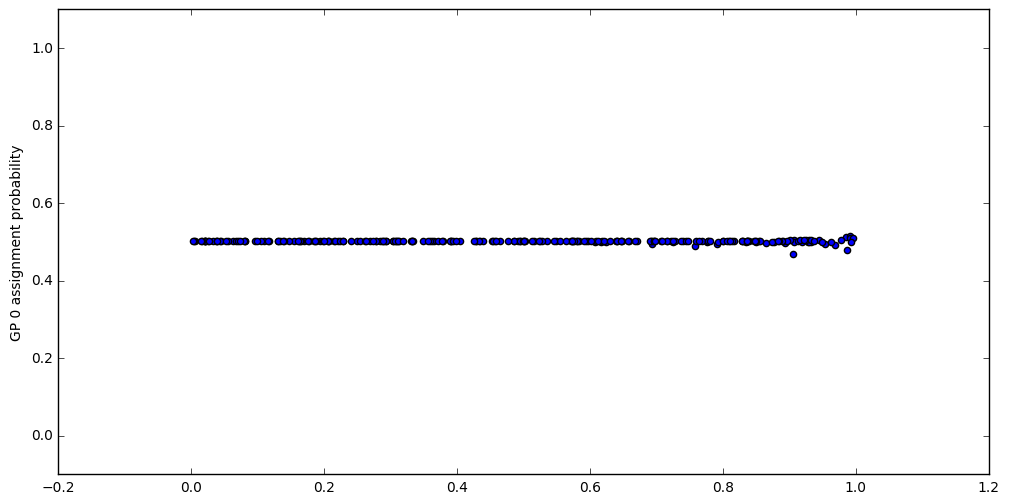

In [9]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [10]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 0.10735622],None,+ve
model.kern.item0.lengthscales,[ 1.1884967],None,+ve
model.kern.item1.lengthscales,[ 1.16954333],None,+ve
model.kern.item1.variance,[ 0.0973496],None,+ve


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [11]:
m.optimize(step_length=0.01, maxiter=200)

iteration 1 bound=1264.56876052 grad=0.00049799535637, beta=0
iteration 2 bound=1264.56877233 grad=0.000491372249696, beta=1.41338005969
iteration 3 bound=1264.56878993 grad=0.000475751196742, beta=1.11481486868
iteration 4 bound=1264.56881232 grad=0.000452851782719, beta=1.04969048543
iteration 5 bound=1264.56883838 grad=0.00042439199382, beta=1.01555871638
iteration 6 bound=1264.56886694 grad=0.000392286004167, beta=0.992451460407
iteration 7 bound=1264.56889686 grad=0.000358456909246, beta=0.975011766637
iteration 8 bound=1264.56892714 grad=0.000324641976566, beta=0.961333539964
iteration 9 bound=1264.56895698 grad=0.000292243958661, beta=0.950715876341
iteration 10 bound=1264.56898579 grad=0.000262250041011, beta=0.942992179871
iteration 11 bound=1264.56901319 grad=0.000235220742923, beta=0.938264269229
iteration 12 bound=1264.56903901 grad=0.000211336597294, beta=0.936748308582
iteration 13 bound=1264.56906323 grad=0.000190481977301, beta=0.938630561137
iteration 14 bound=1264.569

In [12]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 0.10458815],None,+ve
model.kern.item0.lengthscales,[ 1.18387569],None,+ve
model.kern.item1.lengthscales,[ 1.17425406],None,+ve
model.kern.item1.variance,[ 0.09987649],None,+ve


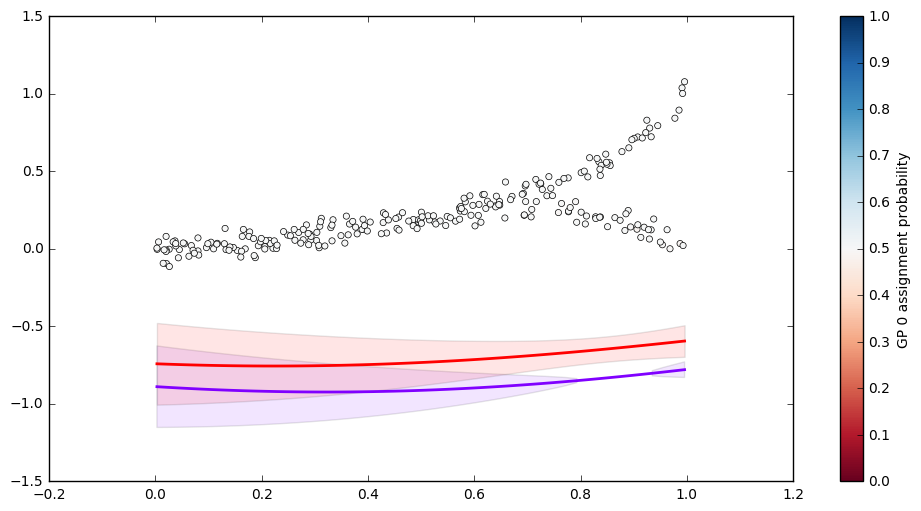

In [13]:
OMGPplot(m,X,Y)

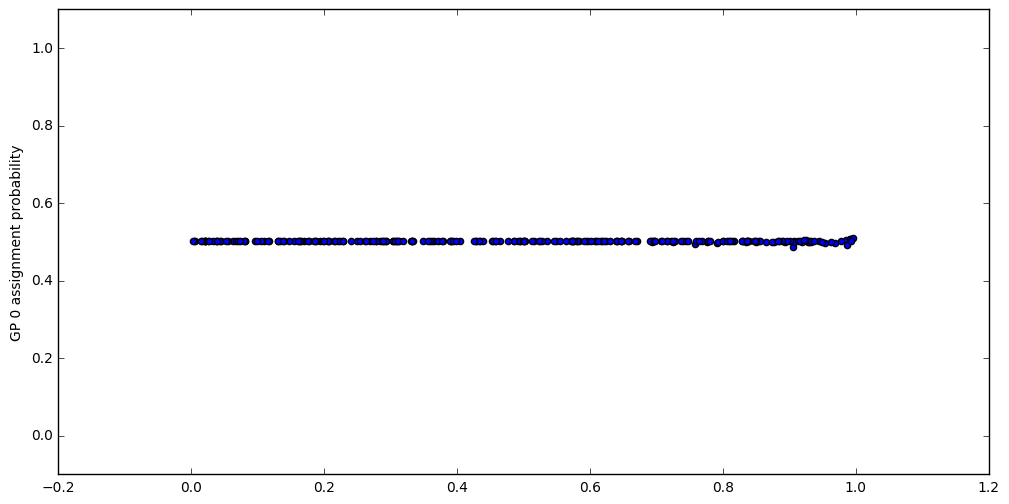

In [14]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [15]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

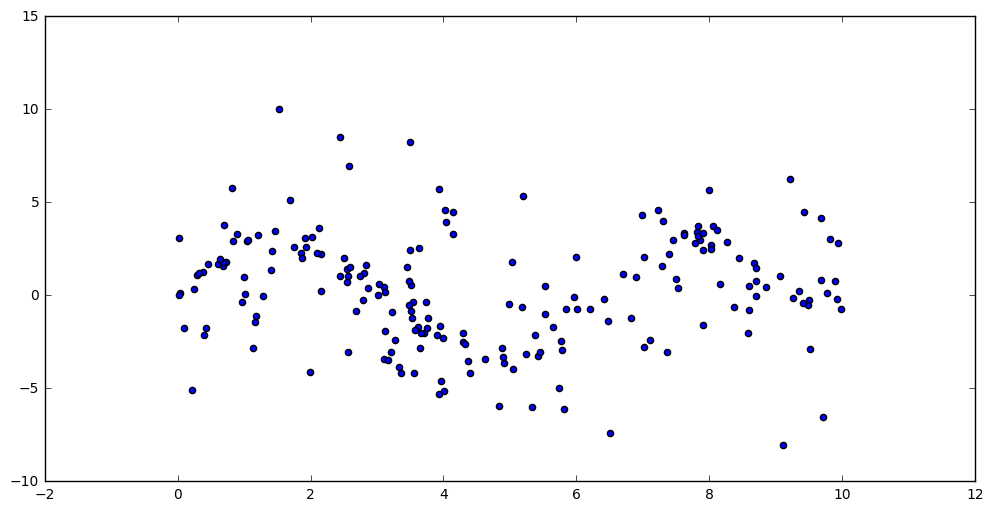

In [16]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [20]:
kernels = [GPflow.kernels.RBF(1,lengthscales=2.0)]
m = OMGP(x, y, num_clusters=1, prior_Z='DP', kernels=kernels,variance=3.)
m.hyperparam_interval = 100

In [21]:
m.optimize(verbose=False)

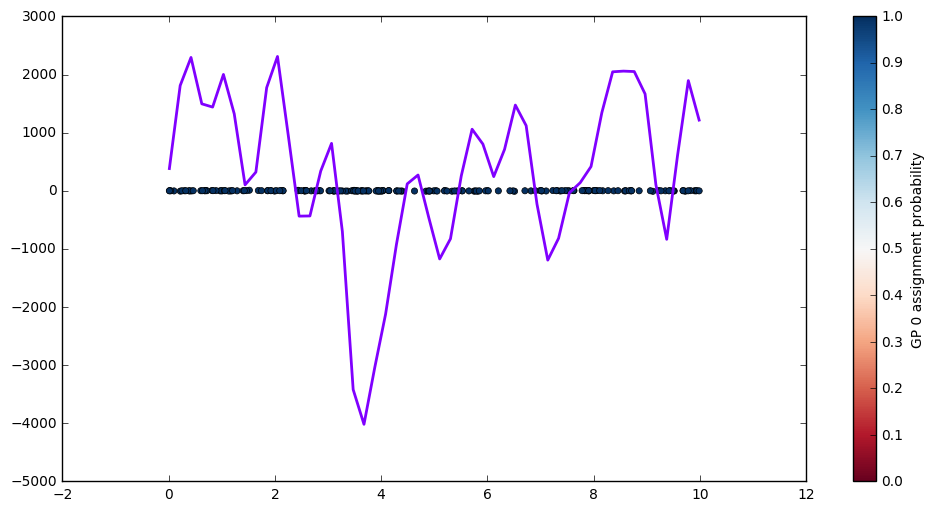

In [23]:
OMGPplot(m,x,y)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [25]:
kernels = [GPflow.kernels.White(1), GPflow.kernels.RBF(1, lengthscales=2.0)]
m = OMGP(x, y, num_clusters=2, prior_Z='DP', kernels=kernels, variance=3.)
m.hyperparam_interval = 250

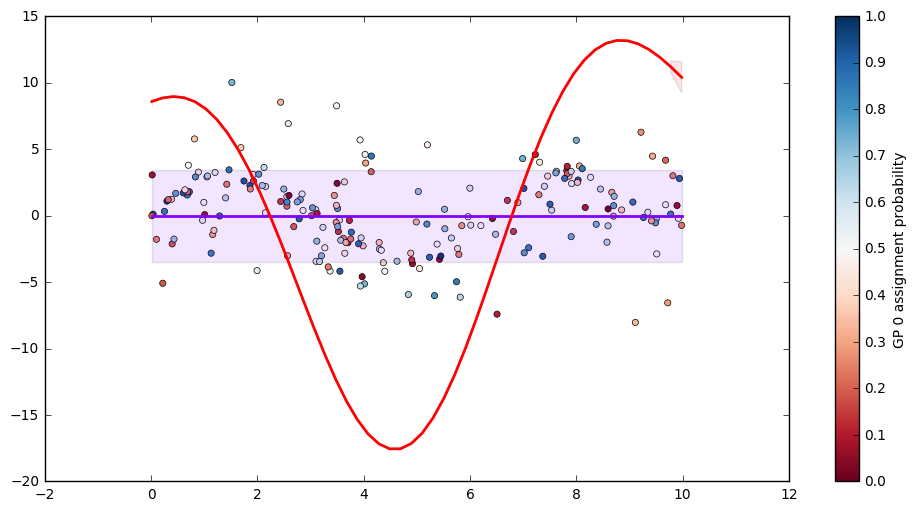

In [27]:
OMGPplot(m,x,y)

In [28]:
m.optimize(step_length=0.01, verbose=False)

In [29]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 7.56375848],None,+ve
model.kern.item1.variance,[ 219.46844873],None,+ve
model.kern.item1.lengthscales,[ 1.79095909],None,+ve


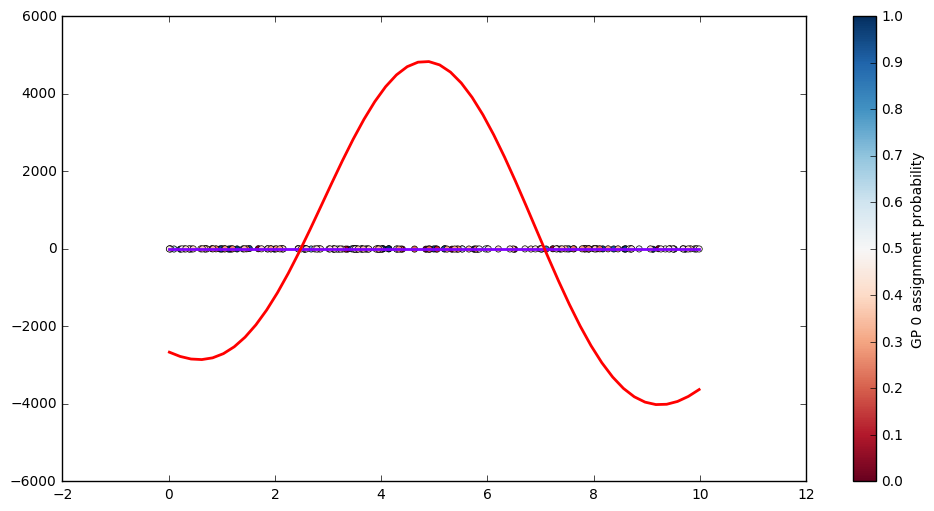

In [30]:
OMGPplot(m,x,y)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

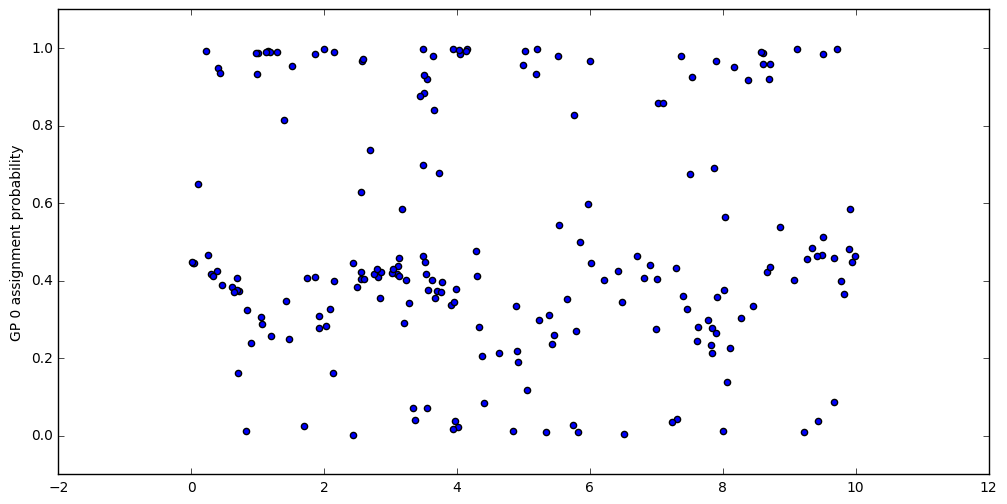

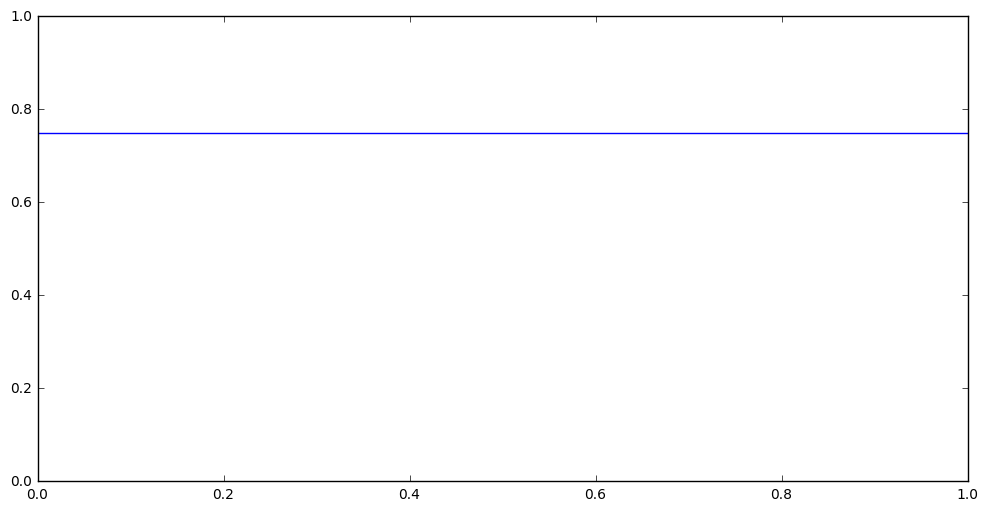

In [31]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [33]:
thr = 0.75
phi = m.get_phi()
idx = np.where(phi[:,0] < thr)[0]
nidx = np.where(phi[:,0] >= thr)[0]

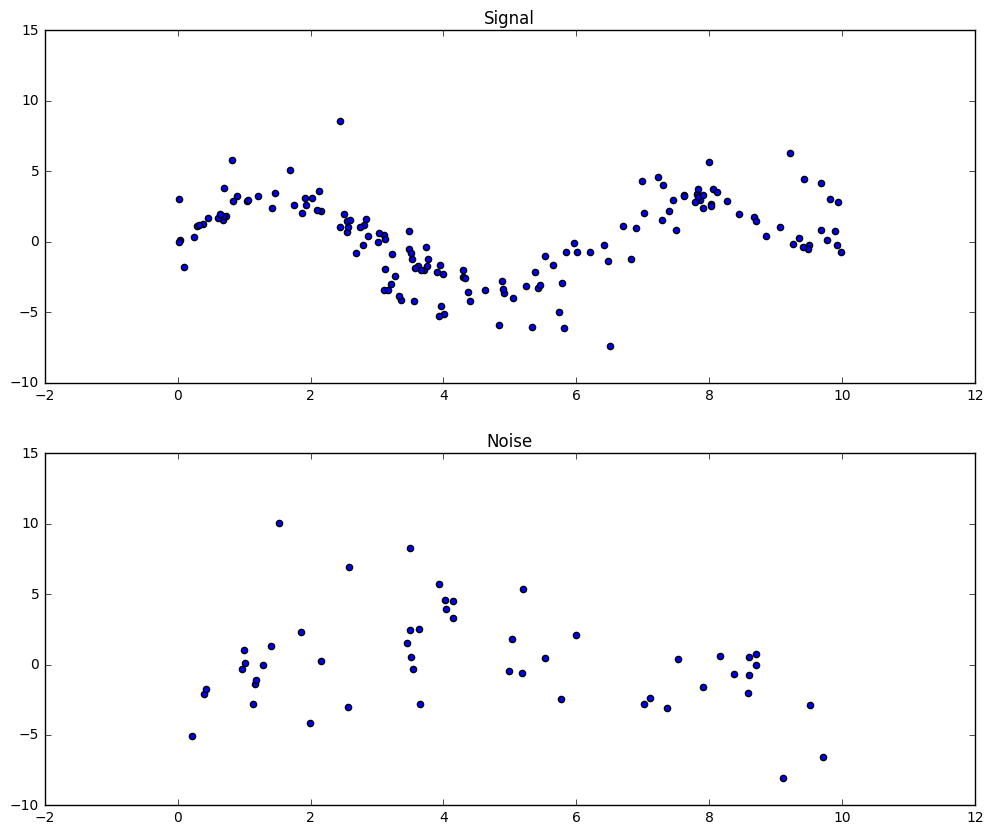

In [34]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');